In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# import os
# os.chdir('/content/drive/MyDrive/NLP_Proj')
# print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/NLP_Proj


In [36]:
# os.listdir()

['classified_counsel_chat_imp.csv',
 'chatBox_app.ipynb',
 'classified_counsel_chat.csv',
 'train.csv',
 'Combined_Data.csv',
 'chroma_db',
 'xgb_model.pkl',
 '.ipynb_checkpoints',
 'logistic_regression_model.pkl',
 'NLP_Proj.ipynb']

In [4]:
# %pip install pandas numpy matplotlib seaborn imblearn nltk scikit-learn xgboost
# %pip install torch torchvision torchaudio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Combined_Data.csv', index_col=0)
print(df.head())
print(df['status'].value_counts())

                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [3]:
df.isna().sum()
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

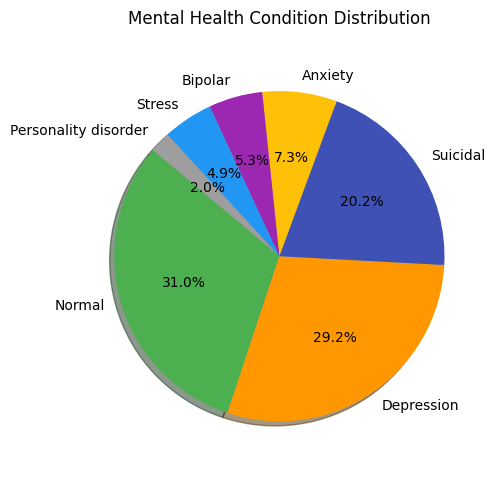

In [4]:
condition_counts = df['status'].value_counts()

color_palette = ['#4CAF50', '#FF9800', '#3F51B5', '#FFC107', '#9C27B0', '#2196F3', '#9E9E9E']


plt.figure(figsize=(5, 5))
plt.pie(
    condition_counts,
    labels=condition_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=color_palette,
    shadow=True
)

plt.title('Mental Health Condition Distribution')
plt.axis('equal')

plt.tight_layout()
plt.show()


In [13]:

sampled_statements = df.groupby('status')['statement'].apply(lambda group: group.sample(1).values[0])

# Display the results in a structured format
for condition, example in sampled_statements.items():
    print(f"Mental Health Condition: {condition}")
    print(f"Example Statement: {example}\n")


Mental Health Condition: Anxiety
Example Statement: WHY DOES ANXIETY HAVE SO MANY RANDOM ASS SYMPTOMS From panic attacks to hyperventilation to chest pains to racing thoughts to dizzyness to lightheadedness to afraid of leaving the house to burning hands? I fucking hate this shit so much. If you got panic attacks and anxiety from weed pleaseeeee share your thoughts on destroying this disease i want to leave my house again i want to mingle with people again i want to be able to get on my fucking computer and do normal shit that everyone does again rather than wrapping myself in my bed sheets all day everyday and taking meds

Mental Health Condition: Bipolar
Example Statement: Does anyone else feel like there should be a childhood bi-polar diagnosis? I read a lot of posts and stories online,  and I think about myself and so many of us seem to have had symptoms early in our lives.  I get that doctors don't want to give a diagnosis like that at such young ages for a lot of reasons,  but I 

In [14]:
import nltk

# Compute text length and sentence count for each statement
df['char_count'] = df['statement'].apply(len)  # Measure character length
df['sentence_count'] = df['statement'].map(lambda text: len(nltk.sent_tokenize(text)))  # Count sentences

# Generate summary statistics for text characteristics
stats_summary = df[['char_count', 'sentence_count']].describe()

# Output the statistical summary
print(stats_summary)

         char_count  sentence_count
count  52681.000000    52681.000000
mean     578.713863        6.280215
std      846.269078       10.688388
min        2.000000        1.000000
25%       80.000000        1.000000
50%      317.000000        3.000000
75%      752.000000        8.000000
max    32759.000000     1260.000000


In [84]:
df[df['char_count'] > 10000]

,statement,status,char_count,sentence_count
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


In [15]:
import re

def clean_text(input_text):
    input_text = input_text.lower()
    # Remove web URLs
    input_text = re.sub(r"https?://\S+", "", input_text)

    # Remove markdown links of the format [text](url)
    input_text = re.sub(r"\[.*?\]\(.*?\)", "", input_text)

    input_text = re.sub(r'\[.*?\]', '', input_text)  # Remove text in square brackets

    # Remove user mentions (handles starting with '@')
    input_text = re.sub(r"@\w+", "", input_text)

    input_text = re.sub(r'\n', '', input_text)

    # Remove punctuation and special characters, keeping only words and spaces
    input_text = re.sub(r"[^\w\s]", "", input_text)

    return input_text.strip()

df = df.rename(columns={'statement': 'text_original'})
df['text_processed'] = df['text_original'].apply(clean_text)
df.head()


,text_original,status,char_count,sentence_count,text_processed
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [16]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['text_processed'].apply(word_tokenize)
df.head()

,text_original,status,char_count,sentence_count,text_processed,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [17]:
from nltk.stem import PorterStemmer


porter = PorterStemmer()


def apply_stemming(word_list):
    return ' '.join(porter.stem(word) for word in word_list)

df['stemmed_tokens'] = df['tokens'].apply(apply_stemming)

df.head()


,text_original,status,char_count,sentence_count,text_processed,tokens,stemmed_tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


In [18]:
df.head()['stemmed_tokens']

0                                           oh my gosh
1    troubl sleep confus mind restless heart all ou...
2    all wrong back off dear forward doubt stay in ...
3    ive shift my focu to someth els but im still w...
4    im restless and restless it been a month now b...
Name: stemmed_tokens, dtype: object

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

features = df[['stemmed_tokens', 'char_count', 'sentence_count']]

target = df['status']

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target.values)

# Save label encoder mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Save the label mapping as a pickle file
with open("label_mapping.pkl", "wb") as file:
    pickle.dump(label_mapping, file)

print("Saved label mapping as label_mapping.pkl")

X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=101)


Saved label mapping as label_mapping.pkl


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Initialize TF-IDF Vectorizer with unigram and bigram features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['stemmed_tokens'])


# Transform test data using the trained vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test['stemmed_tokens'])

# Extract numerical attributes (Character Count & Sentence Count)
X_train_numeric = X_train[['char_count', 'sentence_count']].values
X_test_numeric = X_test[['char_count', 'sentence_count']].values

# Merge TF-IDF Features with Extracted Numerical Features
X_train_final = hstack([X_train_tfidf, X_train_numeric])
X_test_final = hstack([X_test_tfidf, X_test_numeric])

print(f'Total TF-IDF Features: {len(tfidf_vectorizer.get_feature_names_out())}')


TF-IDF Vectorizer saved successfully!
Total TF-IDF Features: 50000


In [90]:
from imblearn.over_sampling import RandomOverSampler

print(X_train_final.shape)
oversampler = RandomOverSampler(random_state=41)

# Perform over-sampling to balance class distribution
X_balanced, y_balanced = oversampler.fit_resample(X_train_final, y_train)

print(f"Resampled training data shape: {X_balanced.shape}")


(42144, 50002)
Resampled training data shape: (91742, 50002)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV

param = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

In [91]:
from sklearn.ensemble import RandomForestClassifier
classifiers = {
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=41),
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=41),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=41, tree_method='gpu_hist'),
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, random_state=41, n_jobs=-1)
}



Model: Decision Tree
Accuracy: 0.6369
                      precision    recall  f1-score   support

             Anxiety       0.68      0.54      0.60       768
             Bipolar       0.44      0.63      0.52       566
          Depression       0.75      0.47      0.57      3050
              Normal       0.86      0.86      0.86      3237
Personality disorder       0.55      0.43      0.48       202
              Stress       0.24      0.79      0.37       530
            Suicidal       0.58      0.56      0.57      2184

            accuracy                           0.64     10537
           macro avg       0.59      0.61      0.57     10537
        weighted avg       0.70      0.64      0.65     10537



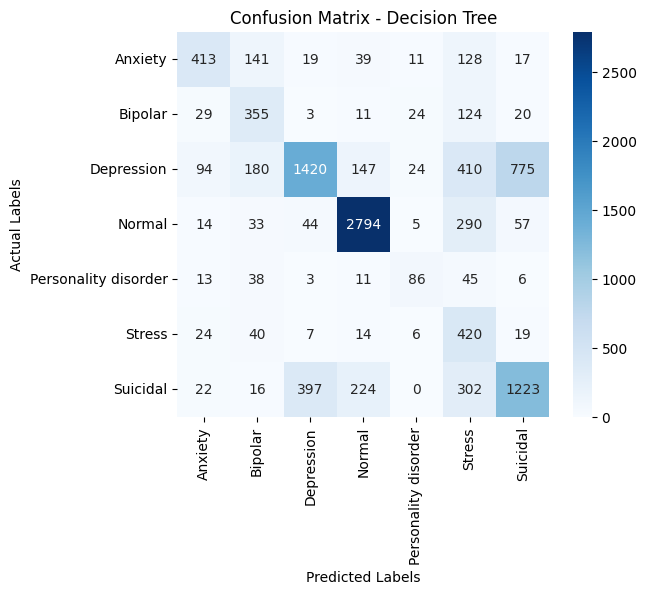

Saved model: decision_tree_model.pkl


Model: Logistic Regression
Accuracy: 0.7638
                      precision    recall  f1-score   support

             Anxiety       0.78      0.80      0.79       768
             Bipolar       0.84      0.80      0.82       566
          Depression       0.72      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.68      0.65      0.66       202
              Stress       0.59      0.64      0.61       530
            Suicidal       0.65      0.68      0.67      2184

            accuracy                           0.76     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.76      0.76      0.76     10537



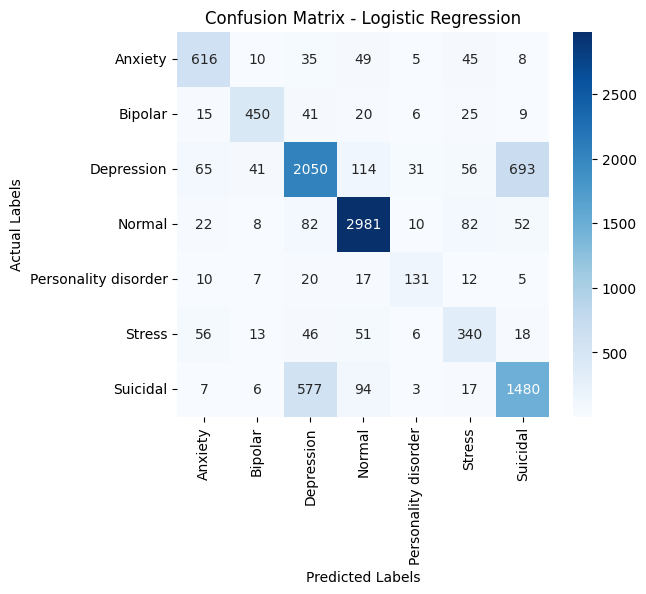

Saved model: logistic_regression_model.pkl


Model: XGB
Accuracy: 0.8115
                      precision    recall  f1-score   support

             Anxiety       0.83      0.87      0.85       768
             Bipolar       0.87      0.82      0.84       566
          Depression       0.79      0.73      0.76      3050
              Normal       0.92      0.94      0.93      3237
Personality disorder       0.81      0.64      0.71       202
              Stress       0.68      0.78      0.73       530
            Suicidal       0.70      0.74      0.72      2184

            accuracy                           0.81     10537
           macro avg       0.80      0.79      0.79     10537
        weighted avg       0.81      0.81      0.81     10537



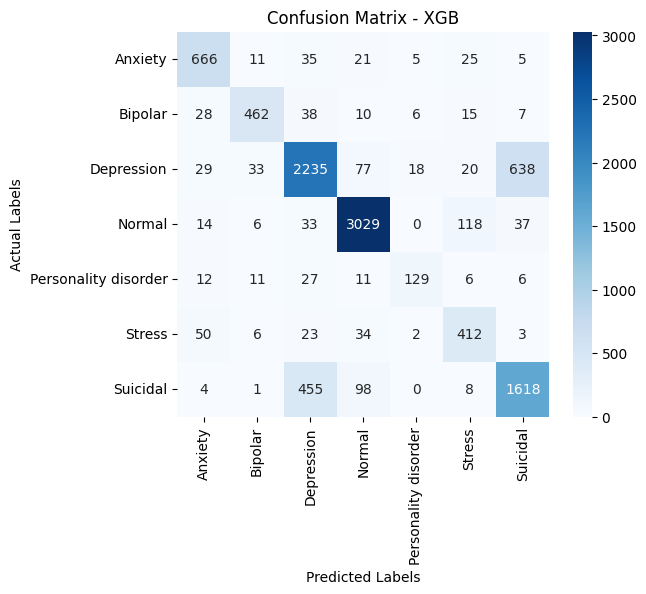

Saved model: xgb_model.pkl


Model: Random Forest
Accuracy: 0.6501
                      precision    recall  f1-score   support

             Anxiety       0.78      0.57      0.66       768
             Bipolar       0.67      0.76      0.71       566
          Depression       0.88      0.32      0.47      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.46      0.69      0.55       202
              Stress       0.41      0.61      0.49       530
            Suicidal       0.58      0.70      0.63      2184

            accuracy                           0.65     10537
           macro avg       0.64      0.65      0.61     10537
        weighted avg       0.70      0.65      0.63     10537



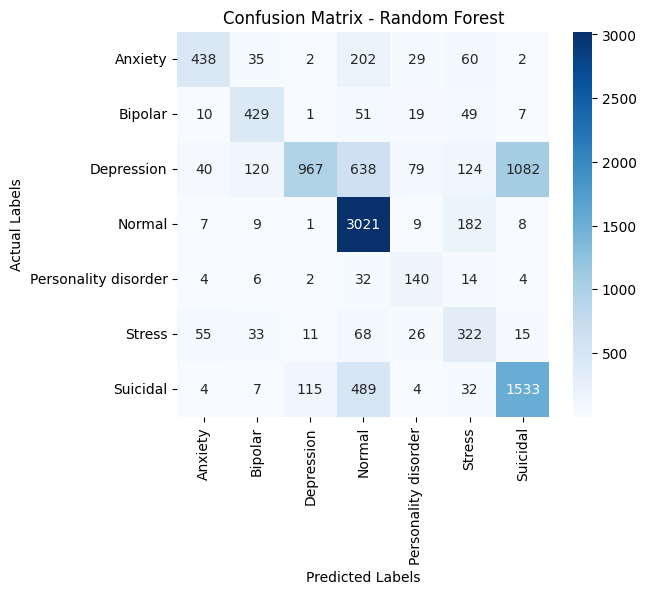

Saved model: random_forest_model.pkl


In [92]:
import pickle

model_accuracies = []


for model_name, model in classifiers.items():

    model.fit(X_balanced, y_balanced)

    predictions = model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)

    print("\n")
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")

    class_labels = label_encoder.classes_
    confusion_mat = confusion_matrix(y_test, predictions)

    print(classification_report(y_test, predictions, target_names=class_labels))

    # Visualize the confusion matrix with a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    model_filename = f"{model_name.replace(' ', '_').lower()}_model.pkl"
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)

    print(f"Saved model: {model_filename}")

    model_accuracies.append(accuracy)

with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(tfidf_vectorizer, file)


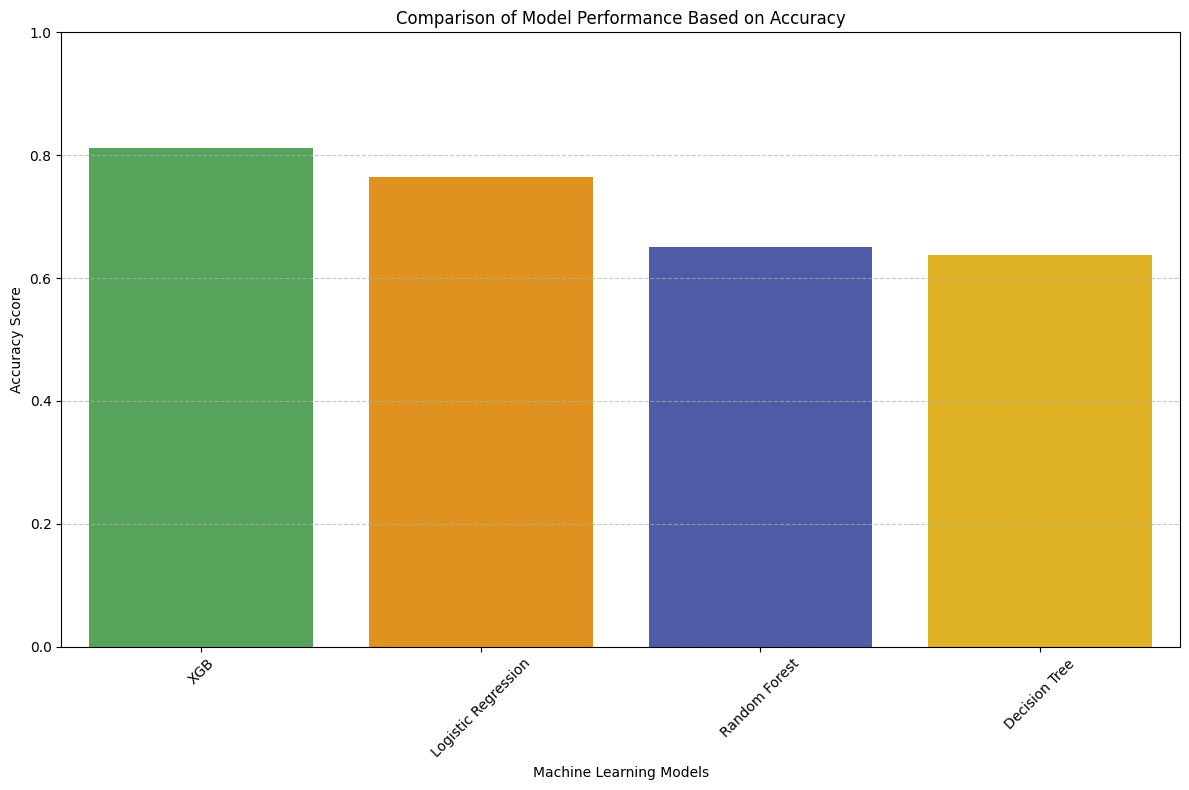

In [93]:

performance_df = pd.DataFrame({'Model': classifiers.keys(), 'Accuracy': model_accuracies})

performance_df = performance_df.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12, 8))

color_mapping = dict(zip(performance_df['Model'], color_palette[:len(performance_df)]))

sns.barplot(x='Model', y='Accuracy', data=performance_df, palette=color_mapping)

plt.title("Comparison of Model Performance Based on Accuracy")
plt.ylim(0, 1)
plt.xlabel("Machine Learning Models")
plt.ylabel("Accuracy Score")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [94]:

import pickle

def load_model(model_name):
    model_filename = f"{model_name.replace(' ', '_').lower()}_model.pkl"
    with open(model_filename, "rb") as file:
        model = pickle.load(file)
    print(f"Loaded model: {model_filename}")
    return model

xgb_model = load_model("XGB")


✅ Loaded model: xgb_model.pkl


In [99]:
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.sparse import hstack

# Load required resources
nltk.download('punkt')
porter = PorterStemmer()

# Define preprocessing function
def preprocess_text(input_text, vectorizer):


    char_count = len(input_text)
    sentence_count = len(nltk.sent_tokenize(input_text))

    cleaned_text = clean_text(input_text)

    tokens = word_tokenize(cleaned_text)

    stemmed_tokens = ' '.join([porter.stem(word) for word in tokens])

    input_tfidf = vectorizer.transform([stemmed_tokens])

    input_numerical_features = np.array([[char_count, sentence_count]])

    input_features = hstack([input_tfidf, input_numerical_features])

    return input_features

user_text = "I feel very anxious today"

processed_input = preprocess_text(user_text, tfidf_vectorizer)

# Make prediction using the loaded XGBoost model
predicted_label = xgb_model.predict(processed_input)[0]
predicted_class = label_encoder.inverse_transform([predicted_label])[0]

print(f"Predicted Category: {predicted_class}")


Predicted Category: Anxiety


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
